In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [4]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160
IMG_SIZE = (160, 160)

In [8]:
total_test

51

In [18]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=batch_size,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [53]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=50,
                                                            image_size=IMG_SIZE)

Found 50 files belonging to 2 classes.


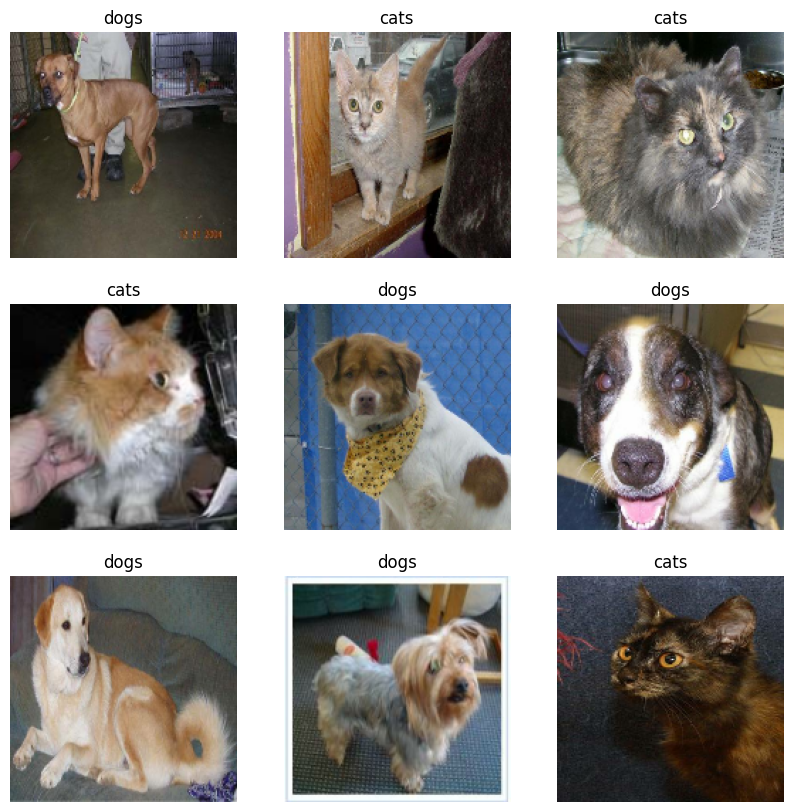

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

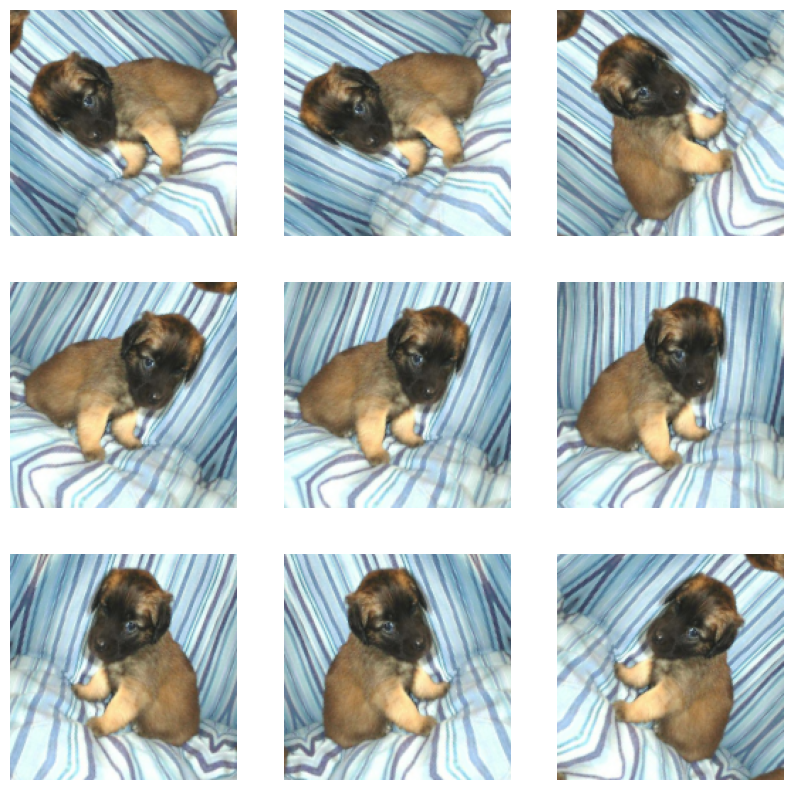

In [19]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [20]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [21]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [22]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [23]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [24]:
base_model.trainable = False

In [25]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [27]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [28]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [29]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [31]:
len(model.trainable_variables)

2

In [34]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

32/32 [==============================] - 7s 209ms/step - loss: 0.7606 - accuracy: 0.5170


In [33]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.76
initial accuracy: 0.52


In [37]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 31s 433ms/step - loss: 0.7053 - accuracy: 0.5920 - val_loss: 0.5134 - val_accuracy: 0.7440
Epoch 2/10
63/63 [==============================] - 34s 541ms/step - loss: 0.5123 - accuracy: 0.7260 - val_loss: 0.3733 - val_accuracy: 0.8410
Epoch 3/10
63/63 [==============================] - 36s 565ms/step - loss: 0.4266 - accuracy: 0.7890 - val_loss: 0.2915 - val_accuracy: 0.8920
Epoch 4/10
63/63 [==============================] - 36s 563ms/step - loss: 0.3443 - accuracy: 0.8365 - val_loss: 0.2393 - val_accuracy: 0.9180
Epoch 5/10
63/63 [==============================] - 42s 669ms/step - loss: 0.3048 - accuracy: 0.8685 - val_loss: 0.2043 - val_accuracy: 0.9320
Epoch 6/10
63/63 [==============================] - 47s 745ms/step - loss: 0.2768 - accuracy: 0.8740 - val_loss: 0.1790 - val_accuracy: 0.9400
Epoch 7/10
63/63 [==============================] - 45s 711ms/step - loss: 0.2536 - accuracy: 0.8870 - val_loss: 0.1606 - val_accuracy: 0.9420

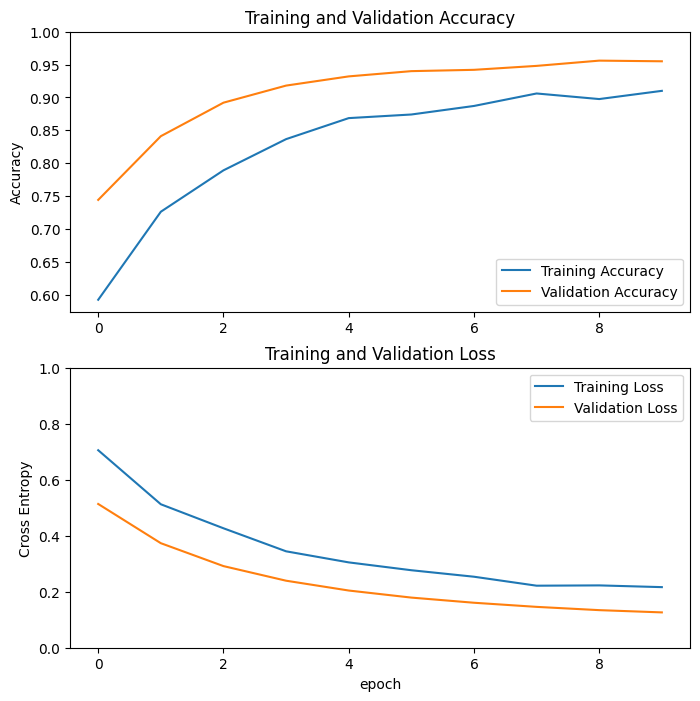

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
base_model.trainable = True

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [41]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [43]:
len(model.trainable_variables)

56

In [44]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 47s 675ms/step - loss: 0.1576 - accuracy: 0.9290 - val_loss: 0.0568 - val_accuracy: 0.9810
Epoch 11/20
63/63 [==============================] - 48s 759ms/step - loss: 0.1407 - accuracy: 0.9415 - val_loss: 0.0726 - val_accuracy: 0.9830
Epoch 12/20
63/63 [==============================] - 47s 753ms/step - loss: 0.1123 - accuracy: 0.9540 - val_loss: 0.0473 - val_accuracy: 0.9850
Epoch 13/20
63/63 [==============================] - 48s 759ms/step - loss: 0.0984 - accuracy: 0.9605 - val_loss: 0.0427 - val_accuracy: 0.9760
Epoch 14/20
63/63 [==============================] - 47s 749ms/step - loss: 0.0936 - accuracy: 0.9630 - val_loss: 0.0488 - val_accuracy: 0.9770
Epoch 15/20
63/63 [==============================] - 48s 755ms/step - loss: 0.0809 - accuracy: 0.9665 - val_loss: 0.0372 - val_accuracy: 0.9840
Epoch 16/20
63/63 [==============================] - 48s 763ms/step - loss: 0.0763 - accuracy: 0.9670 - val_loss: 0.0383 - val_accuracy:

In [46]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

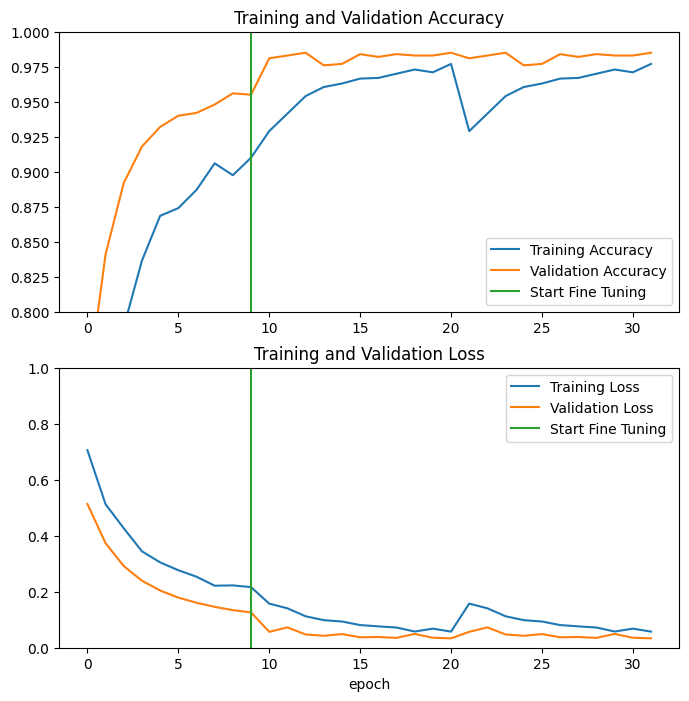

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 594ms/step - loss: 0.1482 - accuracy: 0.9800
Test accuracy : 0.9800000190734863


In [49]:
!mkdir -p saved_model
model.save('saved_model/fcc_cats_dogs')

INFO:tensorflow:Assets written to: saved_model/fcc_cats_dogs\assets


INFO:tensorflow:Assets written to: saved_model/fcc_cats_dogs\assets


In [54]:
test_dataset.class_names

['cats', 'dogs']

Predictions:
 [1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0
 1 1 1 0 0 0 0 0 0 0 0 1 1]
Labels:
 [1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0
 1 1 1 0 0 0 0 0 0 0 0 1 1]
Your model correctly identified 96.0% of the images of cats and dogs.
You passed the challenge!


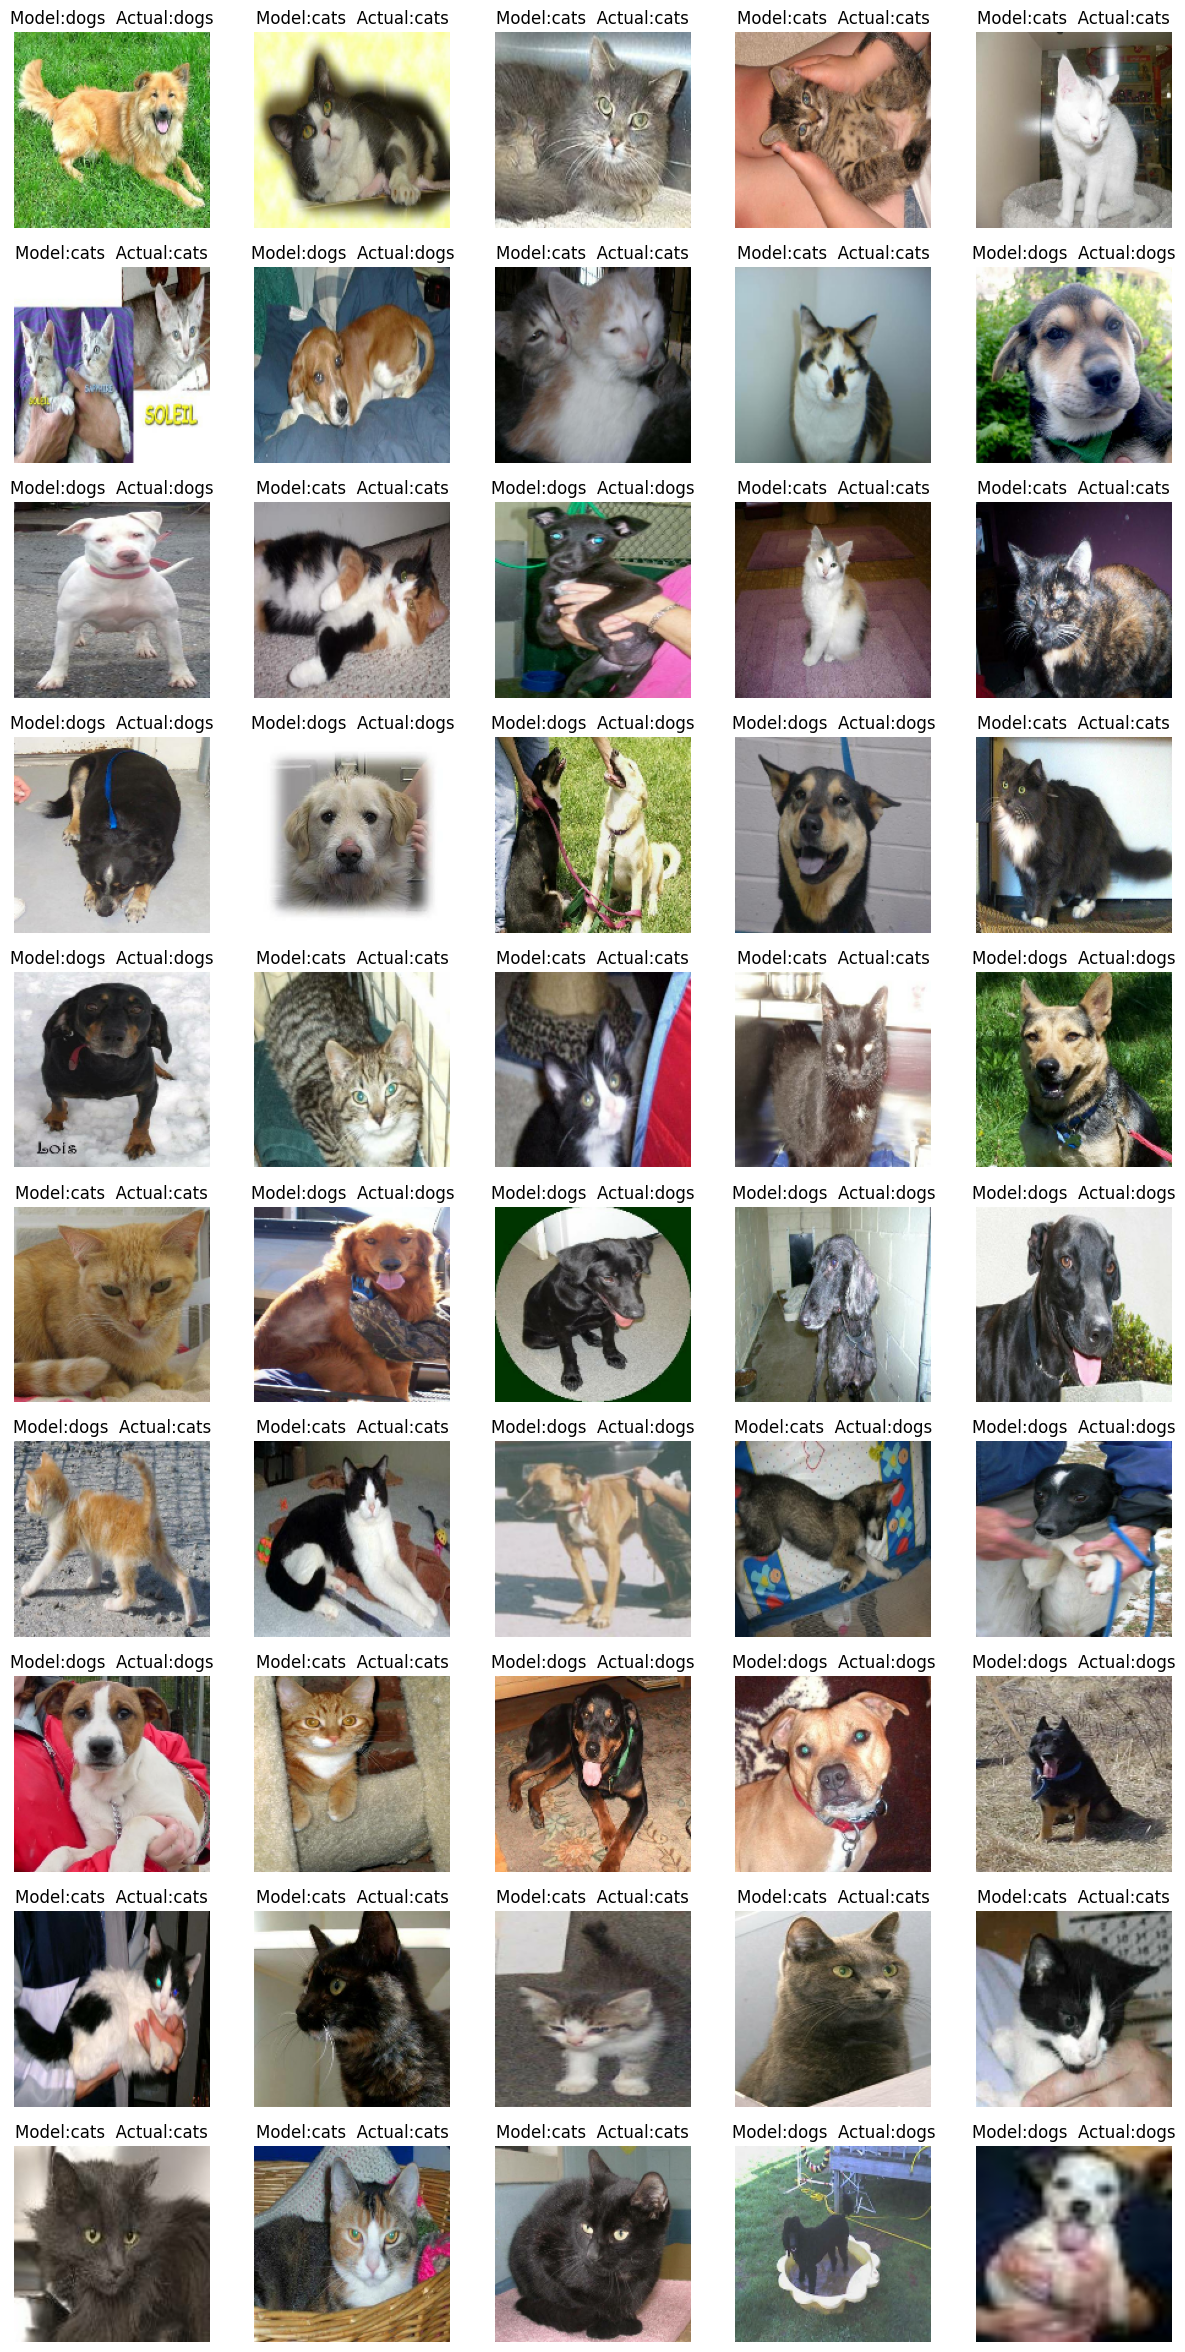

In [55]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

correct = 0

plt.figure(figsize=(15, 30))
for i in range(50):
  ax = plt.subplot(10, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f'Model:{class_names[predictions[i]]}  Actual:{test_dataset.class_names[label_batch[i]]}')
  plt.axis("off")
  if class_names[predictions[i]] == test_dataset.class_names[label_batch[i]]:
    correct += 1

percentage_identified = (correct / 50) * 100
passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")